In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import matplotlib.image as mpimg
import tensorflow as tf
import xml.etree.ElementTree as ET
import os
import random


def parse_labels(filename):
    tree = ET.parse(filename)
    root = tree.getroot()

    polys = []
    for child in root:
        if child.tag == 'object':
            name = child.find('name').text.strip()
            line = []
            for grchild in child.find('polygon'):
                if grchild.tag == 'pt':
                    line.append([int(grchild.find('x').text.strip()), int(grchild.find('y').text.strip())])
            polys.append((name, line))
    return polys

def gen_mask(image_shape, poly):
    m, n = image_shape
    x, y = np.meshgrid(np.arange(n), np.arange(m)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(poly) # make a polygon
    grid = p.contains_points(points)
    mask = grid.reshape(m, n, 1) # now you have a mask with points inside a polygon
    return mask * 1

def select_class(class_name, polys, shape):
    #print([name for name, poly in polys])
    for name, poly in polys:
        if class_name in name:
            mask = gen_mask(shape, poly)
            
    for name, poly in polys:
        if class_name not in name:
            obj_mask = gen_mask(shape, poly)
            mask = (mask - obj_mask == 1) * 1

    return mask

In [2]:
files = []
root = '/home/zaringleb/robot/MIT_dataset'
for place in os.listdir(os.path.join(root, 'indoorCVPR_09annotations/Annotations')):
    for name in os.listdir(os.path.join(root, 'indoorCVPR_09annotations/Annotations', place)):
        with open(os.path.join(root, 'indoorCVPR_09annotations/Annotations', place, name)) as f:
            xml = f.read()
        if 'floor' in xml:
            files.append((os.path.join(root, 'indoorCVPR_09/Images', place, name[:-3] + 'jpg'), os.path.join(root, 'indoorCVPR_09annotations/Annotations', place, name)))
            
print(len(files))

with open(os.path.join(root, 'TestImages.txt')) as f:
    test_images = f.readlines()
test_images = set(line.strip() for line in test_images)


train_dataset = []
test_dataset = []
validation_dataset = []

for f in files:
    if f[0][len(os.path.join(root, 'indoorCVPR_09/Images')) + 1:] in test_images:
        test_dataset.append(f)
    else:
        if random.random() > 0.7:
            validation_dataset.append(f)
        else:
            train_dataset.append(f)
        
len(train_dataset), len(validation_dataset), len(test_dataset)

1608


(1066, 477, 65)

In [3]:
def file_to_element(img, label):
    img = mpimg.imread(img)

    polys = parse_labels(label)
    mask = select_class('floor', polys, img.shape[:2])
    
    return img, mask #{'image': img, 'segmentation_mask': mask}


def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask = int(input_mask == 1)
  return input_image, input_mask


def load_image(*datapoint):
  input_image = tf.image.resize(datapoint[0], (128, 128))
  input_mask = tf.image.resize(datapoint[1], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [36]:
train_dataset_ = [load_image(*file_to_element(img, label)) for img, label in files[:200]]

In [37]:
a = [pair[0] for pair in train_dataset_]
b = [pair[1] for pair in train_dataset_]

train_dataset_3 = tf.data.Dataset.from_tensor_slices((a, b))

In [39]:
test = [load_image(*file_to_element(img, label)) for img, label in files[450:500]]

a = [pair[0] for pair in test]
b = [pair[1] for pair in test]

test = tf.data.Dataset.from_tensor_slices((a, b))
#test_dataset = test.batch(BATCH_SIZE)

(128, 128, 3)


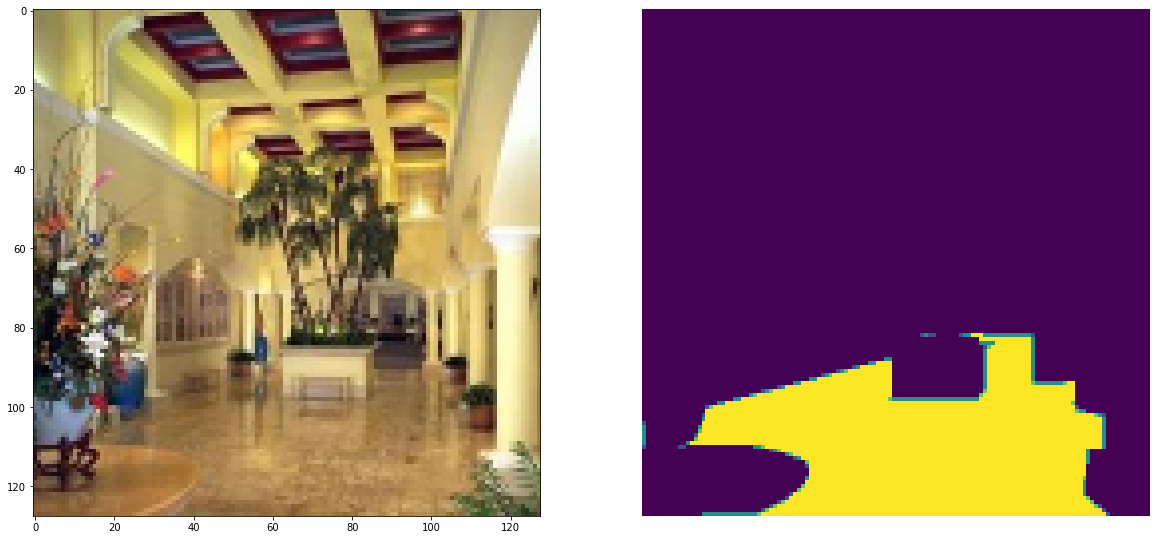

In [40]:
for img, lab in train_dataset_:
    print(img.shape)
    
    plt.figure(figsize=(20, 15))

    plt.subplot(1, 2, 1)
    plt.imshow(img)


    plt.subplot(1, 2, 2)
    plt.imshow(lab)

    plt.axis('off')
    plt.show()
    break

In [10]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [11]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask = int(input_mask == 1)
  return input_image, input_mask


@tf.function
def load_image_train(*datapoint):
  #input_image = tf.image.resize(datapoint[0], (128, 128))
  #input_mask = tf.image.resize(datapoint[1], (128, 128))
    
  input_image = datapoint[0]
  input_mask = datapoint[1]

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  #input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask



In [41]:
TRAIN_LENGTH = 400
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train_dataset_3.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)

In [42]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

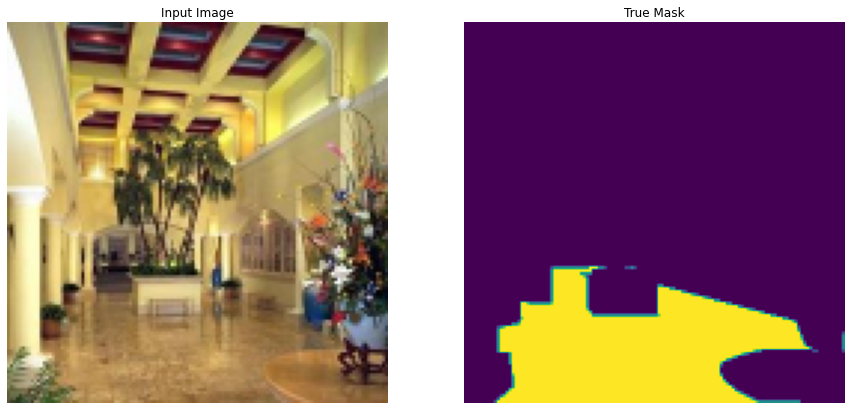

In [44]:
for image, mask in train.take(1):
    display([image, mask])

In [45]:
OUTPUT_CHANNELS = 2


base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [46]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [48]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [49]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  #else:
  #  display([sample_image, sample_mask,
  #           create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [50]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [57]:
BATCH_SIZE

32

In [51]:
test_dataset = test.batch(BATCH_SIZE)

EPOCHS = 10
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=1,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

None

Sample Prediction after epoch 10



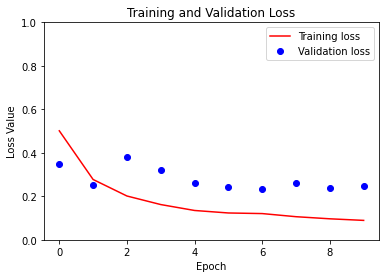

In [52]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


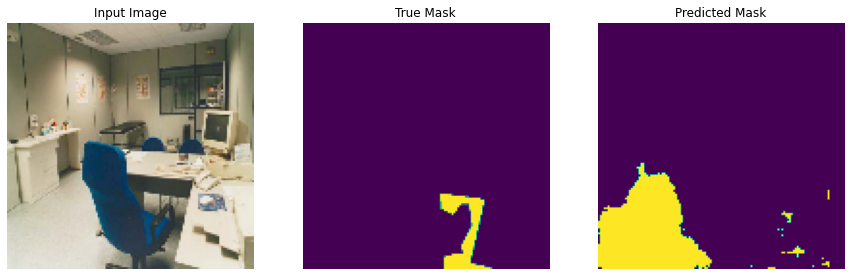

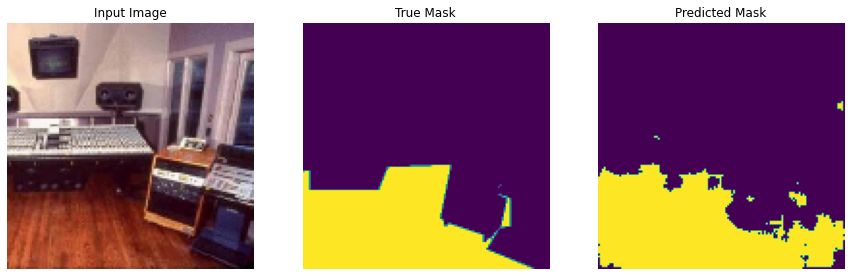

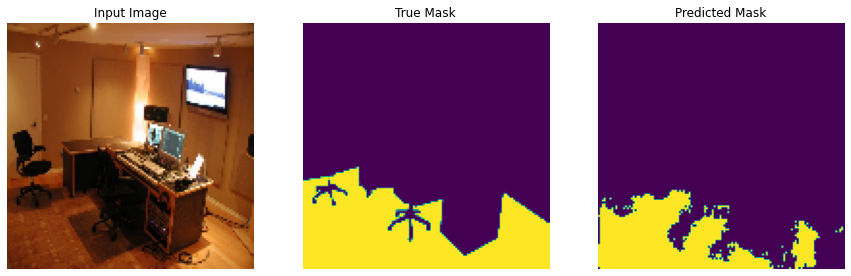

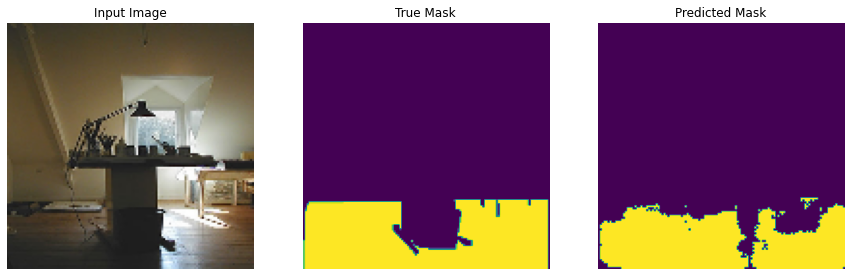

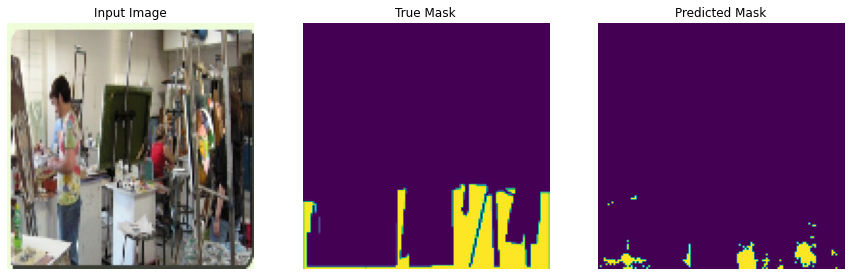

In [58]:
show_predictions(test.batch(10), 10)